Thanks for:

https://www.kaggle.com/ttahara/osic-baseline-lgbm-with-custom-metric

https://www.kaggle.com/carlossouza/bayesian-experiments


## About

In this competition, participants are requiered to predict `FVC` and its **_`Confidence`_**.  
Here, I trained Lightgbm to predict them at the same time by utilizing custom metric.

Most of codes in this notebook are forked from @yasufuminakama 's [lgbm baseline](https://www.kaggle.com/yasufuminakama/osic-lgb-baseline). Thanks!

## Library

In [1]:
import os
import operator
import typing as tp
from logging import getLogger, INFO, StreamHandler, FileHandler, Formatter
from functools import partial


import numpy as np
import pandas as pd
import pymc3 as pm
import random
import math

from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler,LabelEncoder
import category_encoders as ce

from PIL import Image
import cv2
import pydicom

import torch

import lightgbm as lgb
from sklearn.linear_model import Ridge

import warnings
warnings.filterwarnings("ignore")

## Utils

In [2]:
def get_logger(filename='log'):
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=f"{filename}.log")
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

logger = get_logger()


def seed_everything(seed=777):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

## Config

In [3]:
OUTPUT_DICT = './'

ID = 'Patient_Week'
TARGET = 'FVC'
SEED = 42
seed_everything(seed=SEED)

N_FOLD = 4

# Data Loading

In [4]:
train = pd.read_csv('../input/osic-pulmonary-fibrosis-progression/train.csv')
tr = train.copy()
train[ID] = train['Patient'].astype(str) + '_' + train['Weeks'].astype(str)
print(train.shape)
train.head()

(1549, 8)


,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus,Patient_Week
0,ID00007637202177411956430,-4,2315,58.253649,79,Male,Ex-smoker,ID00007637202177411956430_-4
1,ID00007637202177411956430,5,2214,55.712129,79,Male,Ex-smoker,ID00007637202177411956430_5
2,ID00007637202177411956430,7,2061,51.862104,79,Male,Ex-smoker,ID00007637202177411956430_7
3,ID00007637202177411956430,9,2144,53.950679,79,Male,Ex-smoker,ID00007637202177411956430_9
4,ID00007637202177411956430,11,2069,52.063412,79,Male,Ex-smoker,ID00007637202177411956430_11


In [5]:
# construct train input

output = pd.DataFrame()
gb = train.groupby('Patient')
tk0 = tqdm(gb, total=len(gb))
for _, usr_df in tk0:
    usr_output = pd.DataFrame()
    for week, tmp in usr_df.groupby('Weeks'):
        rename_cols = {'Weeks': 'base_Week', 'FVC': 'base_FVC', 'Percent': 'base_Percent', 'Age': 'base_Age'}
        tmp = tmp.drop(columns='Patient_Week').rename(columns=rename_cols)
        drop_cols = ['Age', 'Sex', 'SmokingStatus', 'Percent']
        _usr_output = usr_df.drop(columns=drop_cols).rename(columns={'Weeks': 'predict_Week'}).merge(tmp, on='Patient')
        _usr_output['Week_passed'] = _usr_output['predict_Week'] - _usr_output['base_Week']
        usr_output = pd.concat([usr_output, _usr_output])
    output = pd.concat([output, usr_output])
    
train = output[output['Week_passed']!=0].reset_index(drop=True)
print(train.shape)
train.head()


(12144, 11)


,Patient,predict_Week,FVC,Patient_Week,base_Week,base_FVC,base_Percent,base_Age,Sex,SmokingStatus,Week_passed
0,ID00007637202177411956430,5,2214,ID00007637202177411956430_5,-4,2315,58.253649,79,Male,Ex-smoker,9
1,ID00007637202177411956430,7,2061,ID00007637202177411956430_7,-4,2315,58.253649,79,Male,Ex-smoker,11
2,ID00007637202177411956430,9,2144,ID00007637202177411956430_9,-4,2315,58.253649,79,Male,Ex-smoker,13
3,ID00007637202177411956430,11,2069,ID00007637202177411956430_11,-4,2315,58.253649,79,Male,Ex-smoker,15
4,ID00007637202177411956430,17,2101,ID00007637202177411956430_17,-4,2315,58.253649,79,Male,Ex-smoker,21


In [6]:
# construct test input

test = pd.read_csv('../input/osic-pulmonary-fibrosis-progression/test.csv')
ts = test.copy()

# Create test dataset with Bayesian approach
https://colab.research.google.com/drive/13WTKUlpYEtN0RNhzax_j8gbf84FuU1CF?authuser=1#scrollTo=jUeafaYrv9Em

In [7]:
# PercentをFVCに合わせて補正
# X * Percent / 100 = FVC
# X = FVC * 100 / Percent

dic = {}
for i in range(len(test)):
    X = int(test.FVC[i]*100/test.Percent[i])
    dic[test.Patient[i]] = X
dic

{'ID00419637202311204720264': 4302,
 'ID00421637202311550012437': 3338,
 'ID00422637202311677017371': 2517,
 'ID00423637202312137826377': 4156,
 'ID00426637202313170790466': 4072}

In [8]:
tr = pd.concat([tr, ts], axis=0, ignore_index=True).drop_duplicates()
le_id = LabelEncoder()
tr['PatientID'] = le_id.fit_transform(tr['Patient'])

In [9]:
n_patients = tr['Patient'].nunique()
FVC_obs = tr['FVC'].values
Weeks = tr['Weeks'].values
PatientID = tr['PatientID'].values

with pm.Model() as model_a:
    # create shared variables that can be changed later on
    FVC_obs_shared = pm.Data("FVC_obs_shared", FVC_obs)
    Weeks_shared = pm.Data('Weeks_shared', Weeks)
    PatientID_shared = pm.Data('PatientID_shared', PatientID)
    
    mu_a = pm.Normal('mu_a', mu=1700., sigma=400)
    sigma_a = pm.HalfNormal('sigma_a', 1000.)
    mu_b = pm.Normal('mu_b', mu=-4., sigma=1)
    sigma_b = pm.HalfNormal('sigma_b', 5.)

    a = pm.Normal('a', mu=mu_a, sigma=sigma_a, shape=n_patients)
    b = pm.Normal('b', mu=mu_b, sigma=sigma_b, shape=n_patients)

    # Model error
    sigma = pm.HalfNormal('sigma', 150.)

    FVC_est = a[PatientID_shared] + b[PatientID_shared] * Weeks_shared

    # Data likelihood
    FVC_like = pm.Normal('FVC_like', mu=FVC_est,
                         sigma=sigma, observed=FVC_obs_shared)
    
    # Fitting the model
    trace_a = pm.sample(2000, tune=2000, target_accept=.9, init="adapt_diag")

In [10]:
pred_template = []
for p in tｓ['Patient'].unique():
    df = pd.DataFrame(columns=['PatientID', 'Weeks'])
    df['Weeks'] = np.arange(-12, 134)
    df['Patient'] = p
    pred_template.append(df)
pred_template = pd.concat(pred_template, ignore_index=True)
pred_template['PatientID'] = le_id.transform(pred_template['Patient'])

with model_a:
    pm.set_data({
        "PatientID_shared": pred_template['PatientID'].values.astype(int),
        "Weeks_shared": pred_template['Weeks'].values.astype(int),
        "FVC_obs_shared": np.zeros(len(pred_template)).astype(int),
    })
    post_pred = pm.sample_posterior_predictive(trace_a)

In [11]:
df = pd.DataFrame(columns=['Patient', 'Weeks', 'Patient_Week', 'FVC', 'Confidence'])
df['Patient'] = pred_template['Patient']
df['Weeks'] = pred_template['Weeks']
df['Patient_Week'] = df['Patient'] + '_' + df['Weeks'].astype(str)
df['FVC'] = post_pred['FVC_like'].T.mean(axis=1)
df['Confidence'] = post_pred['FVC_like'].T.std(axis=1)
final = df[['Patient_Week', 'FVC', 'Confidence']]
final.to_csv('submission.csv', index=False)
print(final.shape)
final

(730, 3)


,Patient_Week,FVC,Confidence
0,ID00419637202311204720264_-12,2870.301641,163.130975
1,ID00419637202311204720264_-11,2866.074049,160.873705
2,ID00419637202311204720264_-10,2857.746511,166.752643
3,ID00419637202311204720264_-9,2862.974081,162.884214
4,ID00419637202311204720264_-8,2854.790333,158.146016
...,...,...,...
725,ID00426637202313170790466_129,2708.066948,282.661432
726,ID00426637202313170790466_130,2705.875748,283.841415
727,ID00426637202313170790466_131,2709.644408,285.202737
728,ID00426637202313170790466_132,2702.788976,284.781298


In [12]:
test = test.rename(columns={'Weeks': 'base_Week', 'FVC': 'base_FVC', 'Percent': 'base_Percent', 'Age': 'base_Age'})
submission = pd.read_csv('../input/osic-pulmonary-fibrosis-progression/sample_submission.csv')
submission['Patient'] = submission['Patient_Week'].apply(lambda x: x.split('_')[0])
submission['predict_Week'] = submission['Patient_Week'].apply(lambda x: x.split('_')[1]).astype(int)
test = submission.drop(columns=['FVC', 'Confidence']).merge(test, on='Patient')
test['Week_passed'] = test['predict_Week'] - test['base_Week']
print(test.shape)
test

(730, 10)


,Patient_Week,Patient,predict_Week,base_Week,base_FVC,base_Percent,base_Age,Sex,SmokingStatus,Week_passed
0,ID00419637202311204720264_-12,ID00419637202311204720264,-12,6,3020,70.186855,73,Male,Ex-smoker,-18
1,ID00419637202311204720264_-11,ID00419637202311204720264,-11,6,3020,70.186855,73,Male,Ex-smoker,-17
2,ID00419637202311204720264_-10,ID00419637202311204720264,-10,6,3020,70.186855,73,Male,Ex-smoker,-16
3,ID00419637202311204720264_-9,ID00419637202311204720264,-9,6,3020,70.186855,73,Male,Ex-smoker,-15
4,ID00419637202311204720264_-8,ID00419637202311204720264,-8,6,3020,70.186855,73,Male,Ex-smoker,-14
...,...,...,...,...,...,...,...,...,...,...
725,ID00426637202313170790466_129,ID00426637202313170790466,129,0,2925,71.824968,73,Male,Never smoked,129
726,ID00426637202313170790466_130,ID00426637202313170790466,130,0,2925,71.824968,73,Male,Never smoked,130
727,ID00426637202313170790466_131,ID00426637202313170790466,131,0,2925,71.824968,73,Male,Never smoked,131
728,ID00426637202313170790466_132,ID00426637202313170790466,132,0,2925,71.824968,73,Male,Never smoked,132


In [13]:
test = test.drop(columns='base_FVC').merge(final[["Patient_Week", "FVC"]], on='Patient_Week')
test

,Patient_Week,Patient,predict_Week,base_Week,base_Percent,base_Age,Sex,SmokingStatus,Week_passed,FVC
0,ID00419637202311204720264_-12,ID00419637202311204720264,-12,6,70.186855,73,Male,Ex-smoker,-18,2870.301641
1,ID00419637202311204720264_-11,ID00419637202311204720264,-11,6,70.186855,73,Male,Ex-smoker,-17,2866.074049
2,ID00419637202311204720264_-10,ID00419637202311204720264,-10,6,70.186855,73,Male,Ex-smoker,-16,2857.746511
3,ID00419637202311204720264_-9,ID00419637202311204720264,-9,6,70.186855,73,Male,Ex-smoker,-15,2862.974081
4,ID00419637202311204720264_-8,ID00419637202311204720264,-8,6,70.186855,73,Male,Ex-smoker,-14,2854.790333
...,...,...,...,...,...,...,...,...,...,...
725,ID00426637202313170790466_129,ID00426637202313170790466,129,0,71.824968,73,Male,Never smoked,129,2708.066948
726,ID00426637202313170790466_130,ID00426637202313170790466,130,0,71.824968,73,Male,Never smoked,130,2705.875748
727,ID00426637202313170790466_131,ID00426637202313170790466,131,0,71.824968,73,Male,Never smoked,131,2709.644408
728,ID00426637202313170790466_132,ID00426637202313170790466,132,0,71.824968,73,Male,Never smoked,132,2702.788976


In [14]:
# Percent = FVC * 100 /X

for i in range(len(test)):
    Percent = test.FVC[i]*100 / dic[test.Patient[i]]
    test.base_Percent[i] = Percent
test

,Patient_Week,Patient,predict_Week,base_Week,base_Percent,base_Age,Sex,SmokingStatus,Week_passed,FVC
0,ID00419637202311204720264_-12,ID00419637202311204720264,-12,6,66.720168,73,Male,Ex-smoker,-18,2870.301641
1,ID00419637202311204720264_-11,ID00419637202311204720264,-11,6,66.621898,73,Male,Ex-smoker,-17,2866.074049
2,ID00419637202311204720264_-10,ID00419637202311204720264,-10,6,66.428324,73,Male,Ex-smoker,-16,2857.746511
3,ID00419637202311204720264_-9,ID00419637202311204720264,-9,6,66.549839,73,Male,Ex-smoker,-15,2862.974081
4,ID00419637202311204720264_-8,ID00419637202311204720264,-8,6,66.359608,73,Male,Ex-smoker,-14,2854.790333
...,...,...,...,...,...,...,...,...,...,...
725,ID00426637202313170790466_129,ID00426637202313170790466,129,0,66.504591,73,Male,Never smoked,129,2708.066948
726,ID00426637202313170790466_130,ID00426637202313170790466,130,0,66.450780,73,Male,Never smoked,130,2705.875748
727,ID00426637202313170790466_131,ID00426637202313170790466,131,0,66.543330,73,Male,Never smoked,131,2709.644408
728,ID00426637202313170790466_132,ID00426637202313170790466,132,0,66.374975,73,Male,Never smoked,132,2702.788976


In [15]:
#getting FVC for base week and setting it as base_FVC of patient
def get_base_FVC(data):
    df = data.copy()
    df['min_week'] = df.groupby('Patient')['predict_Week'].transform('min')
    base = df.loc[df.predict_Week == df.min_week][['Patient','FVC']].copy()
    base.columns = ['Patient','base_FVC']
    
    base['nb']=1
    base['nb'] = base.groupby('Patient')['nb'].transform('cumsum')
    
    base = base[base.nb==1]
    base.drop('nb',axis =1,inplace=True)
    df = df.merge(base,on="Patient",how='left')
    df.drop(['min_week'], axis = 1)
    return df 

#For Inference
#getting Number of CT 
def get_N_CT(data, mode="test"):
    df = data.copy()
    N_CT = []
    for pt_id in df.Patient:
      if mode is "test":
        png_dir = os.path.join(image_folder, pt_id)
      if mode is "train":
        png_dir = os.path.join(data_dir, 'train', pt_id)
      files = os.listdir(png_dir)
      N_CT.append(len(files))
    df["N_CT"] = N_CT
    return df

In [16]:
test["min_Weeks"] = np.nan
test = get_base_FVC(test)
test

,Patient_Week,Patient,predict_Week,base_Week,base_Percent,base_Age,Sex,SmokingStatus,Week_passed,FVC,min_Weeks,min_week,base_FVC
0,ID00419637202311204720264_-12,ID00419637202311204720264,-12,6,66.720168,73,Male,Ex-smoker,-18,2870.301641,NaN,-12,2870.301641
1,ID00419637202311204720264_-11,ID00419637202311204720264,-11,6,66.621898,73,Male,Ex-smoker,-17,2866.074049,NaN,-12,2870.301641
2,ID00419637202311204720264_-10,ID00419637202311204720264,-10,6,66.428324,73,Male,Ex-smoker,-16,2857.746511,NaN,-12,2870.301641
3,ID00419637202311204720264_-9,ID00419637202311204720264,-9,6,66.549839,73,Male,Ex-smoker,-15,2862.974081,NaN,-12,2870.301641
4,ID00419637202311204720264_-8,ID00419637202311204720264,-8,6,66.359608,73,Male,Ex-smoker,-14,2854.790333,NaN,-12,2870.301641
...,...,...,...,...,...,...,...,...,...,...,...,...,...
725,ID00426637202313170790466_129,ID00426637202313170790466,129,0,66.504591,73,Male,Never smoked,129,2708.066948,NaN,-12,2949.880691
726,ID00426637202313170790466_130,ID00426637202313170790466,130,0,66.450780,73,Male,Never smoked,130,2705.875748,NaN,-12,2949.880691
727,ID00426637202313170790466_131,ID00426637202313170790466,131,0,66.543330,73,Male,Never smoked,131,2709.644408,NaN,-12,2949.880691
728,ID00426637202313170790466_132,ID00426637202313170790466,132,0,66.374975,73,Male,Never smoked,132,2702.788976,NaN,-12,2949.880691


In [17]:
test = test.drop(['min_Weeks', 'min_week'], axis = 1)
test

,Patient_Week,Patient,predict_Week,base_Week,base_Percent,base_Age,Sex,SmokingStatus,Week_passed,FVC,base_FVC
0,ID00419637202311204720264_-12,ID00419637202311204720264,-12,6,66.720168,73,Male,Ex-smoker,-18,2870.301641,2870.301641
1,ID00419637202311204720264_-11,ID00419637202311204720264,-11,6,66.621898,73,Male,Ex-smoker,-17,2866.074049,2870.301641
2,ID00419637202311204720264_-10,ID00419637202311204720264,-10,6,66.428324,73,Male,Ex-smoker,-16,2857.746511,2870.301641
3,ID00419637202311204720264_-9,ID00419637202311204720264,-9,6,66.549839,73,Male,Ex-smoker,-15,2862.974081,2870.301641
4,ID00419637202311204720264_-8,ID00419637202311204720264,-8,6,66.359608,73,Male,Ex-smoker,-14,2854.790333,2870.301641
...,...,...,...,...,...,...,...,...,...,...,...
725,ID00426637202313170790466_129,ID00426637202313170790466,129,0,66.504591,73,Male,Never smoked,129,2708.066948,2949.880691
726,ID00426637202313170790466_130,ID00426637202313170790466,130,0,66.450780,73,Male,Never smoked,130,2705.875748,2949.880691
727,ID00426637202313170790466_131,ID00426637202313170790466,131,0,66.543330,73,Male,Never smoked,131,2709.644408,2949.880691
728,ID00426637202313170790466_132,ID00426637202313170790466,132,0,66.374975,73,Male,Never smoked,132,2702.788976,2949.880691


In [18]:
submission = pd.read_csv('../input/osic-pulmonary-fibrosis-progression/sample_submission.csv')
print(submission.shape)
submission.head()

(730, 3)


,Patient_Week,FVC,Confidence
0,ID00419637202311204720264_-12,2000,100
1,ID00421637202311550012437_-12,2000,100
2,ID00422637202311677017371_-12,2000,100
3,ID00423637202312137826377_-12,2000,100
4,ID00426637202313170790466_-12,2000,100


# Prepare folds

In [19]:
folds = train[[ID, 'Patient', TARGET]].copy()
#Fold = KFold(n_splits=N_FOLD, shuffle=True, random_state=SEED)
Fold = GroupKFold(n_splits=N_FOLD)
groups = folds['Patient'].values
for n, (train_index, val_index) in enumerate(Fold.split(folds, folds[TARGET], groups)):
    folds.loc[val_index, 'fold'] = int(n)
folds['fold'] = folds['fold'].astype(int)
folds

,Patient_Week,Patient,FVC,fold
0,ID00007637202177411956430_5,ID00007637202177411956430,2214,2
1,ID00007637202177411956430_7,ID00007637202177411956430,2061,2
2,ID00007637202177411956430_9,ID00007637202177411956430,2144,2
3,ID00007637202177411956430_11,ID00007637202177411956430,2069,2
4,ID00007637202177411956430_17,ID00007637202177411956430,2101,2
...,...,...,...,...
12139,ID00426637202313170790466_11,ID00426637202313170790466,2976,0
12140,ID00426637202313170790466_13,ID00426637202313170790466,2712,0
12141,ID00426637202313170790466_19,ID00426637202313170790466,2978,0
12142,ID00426637202313170790466_31,ID00426637202313170790466,2908,0


## Custom Objective / Metric

The competition evaluation metric is:

$
\displaystyle \sigma_{clipped} = \max \left ( \sigma, 70 \right ) \\
\displaystyle \Delta = \min \left ( \|FVC_{ture} - FVC_{predicted}\|, 1000 \right ) \\
\displaystyle f_{metric} = - \frac{\sqrt{2} \Delta}{\sigma_{clipped}} - \ln \left( \sqrt{2} \sigma_{clipped} \right) .
$

This is too complex to directly optimize by custom metric.
Here I use negative loglilelihood loss (_NLL_) of gaussian.  

Let $FVC_{ture}$ is $t$ and $FVC_{predicted}$ is $\mu$, the _NLL_ $l$ is formulated by:

$
\displaystyle l\left( t, \mu, \sigma \right) =
-\ln \left [ \frac{1}{\sqrt{2 \pi} \sigma} \exp \left \{ - \frac{\left(t - \mu \right)^2}{2 \sigma^2} \right \} \right ]
= \frac{\left(t - \mu \right)^2}{2 \sigma^2} + \ln \left( \sqrt{2 \pi} \sigma \right).
$

`grad` and `hess` are calculated as follows:

$
\displaystyle  \frac{\partial l}{\partial \mu } = -\frac{t - \mu}{\sigma^2} \ , \ \frac{\partial^2 l}{\partial \mu^2 } = \frac{1}{\sigma^2}
$

$
\displaystyle \frac{\partial l}{\partial \sigma}
=-\frac{\left(t - \mu \right)^2}{\sigma^3} + \frac{1}{\sigma} = \frac{1}{\sigma} \left\{ 1 - \left ( \frac{t - \mu}{\sigma} \right)^2 \right \}
\\
\displaystyle \frac{\partial^2 l}{\partial \sigma^2}
= -\frac{1}{\sigma^2} \left\{ 1 - \left ( \frac{t - \mu}{\sigma} \right)^2 \right \}
+\frac{1}{\sigma} \frac{2 \left(t - \mu \right)^2 }{\sigma^3}
= -\frac{1}{\sigma^2} \left\{ 1 - 3 \left ( \frac{t - \mu}{\sigma} \right)^2 \right \}
$

For numerical stability, I replace $\sigma$ with $\displaystyle \tilde{\sigma} := \log\left(1 + \mathrm{e}^{\sigma} \right).$

$
\displaystyle l'\left( t, \mu, \sigma \right)
= \frac{\left(t - \mu \right)^2}{2 \tilde{\sigma}^2} + \ln \left( \sqrt{2 \pi} \tilde{\sigma} \right).
$

$
\displaystyle \frac{\partial l'}{\partial \mu } = -\frac{t - \mu}{\tilde{\sigma}^2} \ , \ \frac{\partial^2 l}{\partial \mu^2 } = \frac{1}{\tilde{\sigma}^2}
$
<br>

$
\displaystyle \frac{\partial l'}{\partial \sigma}
= \frac{1}{\tilde{\sigma}} \left\{ 1 - \left ( \frac{t - \mu}{\tilde{\sigma}} \right)^2 \right \} \frac{\partial \tilde{\sigma}}{\partial \sigma}
\\
\displaystyle \frac{\partial^2 l'}{\partial \sigma^2}
= -\frac{1}{\tilde{\sigma}^2}  \left\{ 1 - 3 \left ( \frac{t - \mu}{\tilde{\sigma}} \right)^2 \right \}
\left( \frac{\partial \tilde{\sigma}}{\partial \sigma} \right) ^2
+\frac{1}{\tilde{\sigma}} \left\{ 1 - \left ( \frac{t - \mu}{\tilde{\sigma}} \right)^2 \right \} \frac{\partial^2 \tilde{\sigma}}{\partial \sigma^2}
$

, where  

$
\displaystyle
\frac{\partial \tilde{\sigma}}{\partial \sigma} = \frac{1}{1 + \mathrm{e}^{-\sigma}} \\
\displaystyle
\frac{\partial^2 \tilde{\sigma}}{\partial^2 \sigma} = \frac{\mathrm{e}^{-\sigma}}{\left( 1 + \mathrm{e}^{-\sigma} \right)^2}
= \frac{\partial \tilde{\sigma}}{\partial \sigma} \left( 1 - \frac{\partial \tilde{\sigma}}{\partial \sigma} \right)
$

In [20]:
class OSICLossForLGBM:
    """
    Custom Loss for LightGBM.
    
    * Objective: return grad & hess of NLL of gaussian
    * Evaluation: return competition metric
    """
    
    def __init__(self, epsilon: float=1) -> None:
        """Initialize."""
        self.name = "osic_loss"
        self.n_class = 2  # FVC & Confidence
        self.epsilon = epsilon
    
    def __call__(self, preds: np.ndarray, labels: np.ndarray, weight: tp.Optional[np.ndarray]=None) -> float:
        """Calc loss."""
        sigma_clip = np.maximum(preds[:, 1], 70)
        Delta = np.minimum(np.abs(preds[:, 0] - labels), 1000)
        loss_by_sample = - np.sqrt(2) * Delta / sigma_clip - np.log(np.sqrt(2) * sigma_clip)
        loss = np.average(loss_by_sample, weight)
        
        return loss
    
    def _calc_grad_and_hess(
        self, preds: np.ndarray, labels: np.ndarray, weight: tp.Optional[np.ndarray]=None
    ) -> tp.Tuple[np.ndarray]:
        """Calc Grad and Hess"""
        mu = preds[:, 0]
        sigma = preds[:, 1]
        
        sigma_t = np.log(1 + np.exp(sigma))
        grad_sigma_t = 1 / (1 + np.exp(- sigma))
        hess_sigma_t = grad_sigma_t * (1 - grad_sigma_t)
        
        grad = np.zeros_like(preds)
        hess = np.zeros_like(preds)
        grad[:, 0] = - (labels - mu) / sigma_t ** 2
        hess[:, 0] = 1 / sigma_t ** 2
        
        tmp = ((labels - mu) / sigma_t) ** 2
        grad[:, 1] = 1 / sigma_t * (1 - tmp) * grad_sigma_t
        hess[:, 1] = (
            - 1 / sigma_t ** 2 * (1 - 3 * tmp) * grad_sigma_t ** 2
            + 1 / sigma_t * (1 - tmp) * hess_sigma_t
        )
        if weight is not None:
            grad = grad * weight[:, None]
            hess = hess * weight[:, None]
        return grad, hess
    
    def return_loss(self, preds: np.ndarray, data: lgb.Dataset) -> tp.Tuple[str, float, bool]:
        """Return Loss for lightgbm"""
        labels = data.get_label()
        weight = data.get_weight()
        n_example = len(labels)
        
        # # reshape preds: (n_class * n_example,) => (n_class, n_example) =>  (n_example, n_class)
        preds = preds.reshape(self.n_class, n_example).T
        # # calc loss
        loss = self(preds, labels, weight)
        
        return self.name, loss, True
    
    def return_grad_and_hess(self, preds: np.ndarray, data: lgb.Dataset) -> tp.Tuple[np.ndarray]:
        """Return Grad and Hess for lightgbm"""
        labels = data.get_label()
        weight = data.get_weight()
        n_example = len(labels)
        
        # # reshape preds: (n_class * n_example,) => (n_class, n_example) =>  (n_example, n_class)
        preds = preds.reshape(self.n_class, n_example).T
        # # calc grad and hess.
        grad, hess =  self._calc_grad_and_hess(preds, labels, weight)

        # # reshape grad, hess: (n_example, n_class) => (n_class, n_example) => (n_class * n_example,) 
        grad = grad.T.reshape(n_example * self.n_class)
        hess = hess.T.reshape(n_example * self.n_class)
        
        return grad, hess

## Training Utils

In [21]:
#===========================================================
# model
#===========================================================
def run_single_lightgbm(
    model_param, fit_param, train_df, test_df, folds, features, target,
    fold_num=0, categorical=[], my_loss=None,
):
    trn_idx = folds[folds.fold != fold_num].index
    val_idx = folds[folds.fold == fold_num].index
    logger.info(f'len(trn_idx) : {len(trn_idx)}')
    logger.info(f'len(val_idx) : {len(val_idx)}')
    
    if categorical == []:
        trn_data = lgb.Dataset(
            train_df.iloc[trn_idx][features], label=target.iloc[trn_idx])
        val_data = lgb.Dataset(
            train_df.iloc[val_idx][features], label=target.iloc[val_idx])
    else:
        trn_data = lgb.Dataset(
            train_df.iloc[trn_idx][features], label=target.iloc[trn_idx],
            categorical_feature=categorical)
        val_data = lgb.Dataset(
            train_df.iloc[val_idx][features], label=target.iloc[val_idx],
            categorical_feature=categorical)

    oof = np.zeros((len(train_df), 2))
    predictions = np.zeros((len(test_df), 2))
    
    best_model_str = [""]
    clf = lgb.train(
        model_param, trn_data, **fit_param,
        valid_sets=[trn_data, val_data],
        fobj=my_loss.return_grad_and_hess,
        feval=my_loss.return_loss,
    )
    oof[val_idx] = clf.predict(train_df.iloc[val_idx][features], num_iteration=clf.best_iteration)

    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = features
    fold_importance_df["importance"] = clf.feature_importance(importance_type='gain')
    fold_importance_df["fold"] = fold_num

    predictions += clf.predict(test_df[features], num_iteration=clf.best_iteration)
    
    # RMSE
    logger.info("fold{} RMSE score: {:<8.5f}".format(
        fold_num, np.sqrt(mean_squared_error(target[val_idx], oof[val_idx, 0]))))
    # Competition Metric
    logger.info("fold{} Metric: {:<8.5f}".format(
        fold_num, my_loss(oof[val_idx], target[val_idx])))
    
    return oof, predictions, fold_importance_df


def run_kfold_lightgbm(
    model_param, fit_param, train, test, folds,
    features, target, n_fold=5, categorical=[], my_loss=None,
):
    
    logger.info(f"================================= {n_fold}fold lightgbm =================================")
    
    oof = np.zeros((len(train), 2))
    predictions = np.zeros((len(test), 2))
    feature_importance_df = pd.DataFrame()

    for fold_ in range(n_fold):
        print("Fold {}".format(fold_))
        _oof, _predictions, fold_importance_df =\
            run_single_lightgbm(
                model_param, fit_param, train, test, folds,
                features, target, fold_num=fold_, categorical=categorical, my_loss=my_loss
            )
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        oof += _oof
        predictions += _predictions / n_fold

    # RMSE
    logger.info("CV RMSE score: {:<8.5f}".format(np.sqrt(mean_squared_error(target, oof[:, 0]))))
    # Metric
    logger.info("CV Metric: {:<8.5f}".format(my_loss(oof, target)))
                

    logger.info(f"=========================================================================================")
    
    return feature_importance_df, predictions, oof

    
def show_feature_importance(feature_importance_df, name):
    cols = (feature_importance_df[["Feature", "importance"]]
            .groupby("Feature")
            .mean()
            .sort_values(by="importance", ascending=False)[:50].index)
    best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

    #plt.figure(figsize=(8, 16))
    plt.figure(figsize=(6, 4))
    sns.barplot(x="importance", y="Feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('Features importance (averaged/folds)')
    plt.tight_layout()
    plt.savefig(OUTPUT_DICT+f'feature_importance_{name}.png')

## predict FVC & Confidence(signa)

================================= 4fold lightgbm =================================
len(trn_idx) : 9110
len(val_idx) : 3034


Fold 0
Training until validation scores don't improve for 500 rounds
[100]	training's osic_loss: -8.54927	valid_1's osic_loss: -8.14521
[200]	training's osic_loss: -7.90644	valid_1's osic_loss: -7.51034
[300]	training's osic_loss: -7.03552	valid_1's osic_loss: -6.82298
[400]	training's osic_loss: -6.71988	valid_1's osic_loss: -6.62984
[500]	training's osic_loss: -6.70617	valid_1's osic_loss: -6.63415
[600]	training's osic_loss: -6.69925	valid_1's osic_loss: -6.63909
[700]	training's osic_loss: -6.69346	valid_1's osic_loss: -6.64388
[800]	training's osic_loss: -6.68884	valid_1's osic_loss: -6.6425


fold0 RMSE score: 182.24100
fold0 Metric: -6.62726
len(trn_idx) : 9110
len(val_idx) : 3034


Early stopping, best iteration is:
[386]	training's osic_loss: -6.72361	valid_1's osic_loss: -6.62726
Fold 1
Training until validation scores don't improve for 500 rounds
[100]	training's osic_loss: -8.26457	valid_1's osic_loss: -8.57576
[200]	training's osic_loss: -7.75192	valid_1's osic_loss: -8.13803
[300]	training's osic_loss: -6.9716	valid_1's osic_loss: -7.23248
[400]	training's osic_loss: -6.68429	valid_1's osic_loss: -6.84125
[500]	training's osic_loss: -6.66671	valid_1's osic_loss: -6.84979
[600]	training's osic_loss: -6.65815	valid_1's osic_loss: -6.85859
[700]	training's osic_loss: -6.6534	valid_1's osic_loss: -6.87202
[800]	training's osic_loss: -6.64899	valid_1's osic_loss: -6.88719
[900]	training's osic_loss: -6.64515	valid_1's osic_loss: -6.91294
Early stopping, best iteration is:
[444]	training's osic_loss: -6.67532	valid_1's osic_loss: -6.83993


fold1 RMSE score: 300.74151
fold1 Metric: -6.83993
len(trn_idx) : 9100
len(val_idx) : 3044


Fold 2
Training until validation scores don't improve for 500 rounds
[100]	training's osic_loss: -8.20795	valid_1's osic_loss: -8.68242
[200]	training's osic_loss: -7.60309	valid_1's osic_loss: -8.30384
[300]	training's osic_loss: -6.88122	valid_1's osic_loss: -7.32706
[400]	training's osic_loss: -6.63438	valid_1's osic_loss: -6.90937
[500]	training's osic_loss: -6.62063	valid_1's osic_loss: -6.91649
[600]	training's osic_loss: -6.61414	valid_1's osic_loss: -6.92616
[700]	training's osic_loss: -6.60824	valid_1's osic_loss: -6.93508
[800]	training's osic_loss: -6.6025	valid_1's osic_loss: -6.94261


fold2 RMSE score: 258.38212
fold2 Metric: -6.90741
len(trn_idx) : 9112
len(val_idx) : 3032


[900]	training's osic_loss: -6.59777	valid_1's osic_loss: -6.94577
Early stopping, best iteration is:
[414]	training's osic_loss: -6.63152	valid_1's osic_loss: -6.90741
Fold 3
Training until validation scores don't improve for 500 rounds
[100]	training's osic_loss: -8.39105	valid_1's osic_loss: -8.69282
[200]	training's osic_loss: -7.73207	valid_1's osic_loss: -8.00953
[300]	training's osic_loss: -6.94658	valid_1's osic_loss: -7.14046
[400]	training's osic_loss: -6.67413	valid_1's osic_loss: -6.80623
[500]	training's osic_loss: -6.6622	valid_1's osic_loss: -6.80604
[600]	training's osic_loss: -6.6556	valid_1's osic_loss: -6.80807
[700]	training's osic_loss: -6.65099	valid_1's osic_loss: -6.81474
[800]	training's osic_loss: -6.64748	valid_1's osic_loss: -6.8321
[900]	training's osic_loss: -6.64452	valid_1's osic_loss: -6.84099
Early stopping, best iteration is:
[485]	training's osic_loss: -6.66325	valid_1's osic_loss: -6.80371


fold3 RMSE score: 250.65666
fold3 Metric: -6.80371
CV RMSE score: 251.62422
CV Metric: -6.79467


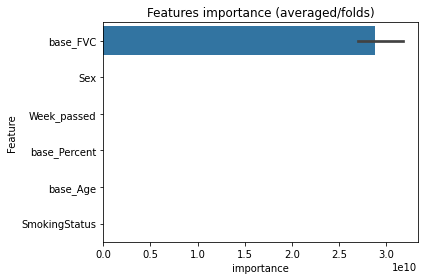

In [22]:
target = train[TARGET]
test[TARGET] = np.nan

# features
cat_features = ['Sex', 'SmokingStatus']
num_features = [c for c in test.columns if (test.dtypes[c] != 'object') & (c not in cat_features)]
features = num_features + cat_features
drop_features = [ID, TARGET, 'predict_Week', 'base_Week']
features = [c for c in features if c not in drop_features]

if cat_features:
    ce_oe = ce.OrdinalEncoder(cols=cat_features, handle_unknown='impute')
    ce_oe.fit(train)
    train = ce_oe.transform(train)
    test = ce_oe.transform(test)
        
lgb_model_param = {
    'num_class': 2,
    # 'objective': 'regression',
    'metric': 'None',
    'boosting_type': 'gbdt',
    'learning_rate': 5e-02,
    'seed': SEED,
    "subsample": 0.4,
    "subsample_freq": 1,
    'max_depth': 1,
    'verbosity': -1,
}
lgb_fit_param = {
    "num_boost_round": 10000,
    "verbose_eval":100,
    "early_stopping_rounds": 500,
}

feature_importance_df, predictions, oof = run_kfold_lightgbm(
    lgb_model_param, lgb_fit_param, train, test,
    folds, features, target,
    n_fold=N_FOLD, categorical=cat_features, my_loss=OSICLossForLGBM())
    
show_feature_importance(feature_importance_df, TARGET)

In [23]:
oof[:5, :]

array([[2211.55138742,  197.78147584],
       [2208.07923761,  197.78147584],
       [2201.49307779,  199.15640342],
       [2196.67544742,  199.15640342],
       [2180.06100753,  199.15640342]])

In [24]:
predictions[:5]

array([[2918.29889625,  193.98903928],
       [2916.66379917,  193.98903928],
       [2916.66379917,  193.69519776],
       [2916.66379917,  193.69519776],
       [2914.48903764,  193.69519776]])

In [25]:
train["FVC_pred"] = oof[:, 0]
train["Confidence"] = oof[:, 1]
test["FVC_pred"] = predictions[:, 0]
test["Confidence"] = predictions[:, 1]

# Submission

In [26]:
submission.head()

,Patient_Week,FVC,Confidence
0,ID00419637202311204720264_-12,2000,100
1,ID00421637202311550012437_-12,2000,100
2,ID00422637202311677017371_-12,2000,100
3,ID00423637202312137826377_-12,2000,100
4,ID00426637202313170790466_-12,2000,100


In [27]:
sub = submission.drop(columns=['FVC', 'Confidence']).merge(test[['Patient_Week', 'FVC_pred', 'Confidence']], 
                                                           on='Patient_Week')
sub.columns = submission.columns
sub.to_csv('submission.csv', index=False)
sub.head()

,Patient_Week,FVC,Confidence
0,ID00419637202311204720264_-12,2918.298896,193.989039
1,ID00421637202311550012437_-12,2923.259868,207.987997
2,ID00422637202311677017371_-12,2135.433076,188.904551
3,ID00423637202312137826377_-12,3158.005049,205.453963
4,ID00426637202313170790466_-12,3022.654191,192.800176
